## <code style='color:turquoise'>Campanhas de marketing direto de uma instituição bancária portuguesa </code>
    Projeto relacionado com campanhas de marketing direto de uma instituição bancária portuguesa, para avaliar se o produto (depósito a prazo bancário) seria (ou não) subscrito.
    Ao final, iremos apresentar um modelo de regressão logística e avaliar sua qualidade em diferentes tipos de objetivo : 
- decisão
- ordenação
- estimação

### <code style='color:green'>Importando os pacotes </code>

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.stats import variation, pearsonr, kurtosis, skew, shapiro, pearsonr, kruskal, boxcox
import seaborn as sns
import numpy as np
from statistics import covariance
from scikit_posthocs import posthoc_dunn
import statsmodels as sm
import statsmodels.api as sma
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats import anova, api
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

import eda_lib as eda
import regressao_log_lib as rl
import hipoteses_lib as ht
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

### <code style="color:green">Carregando o dataset </code>

In [130]:
# Carregando o dataset
df_bank_marketing = pd.read_csv('../data/bank.csv', sep=';')

### <code style="color:green"> Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |  |
| job    | categórico | Tipo de trabalho | | 
| marital   | categórico| Estado civil | | 
| education    | categórico| Educação | |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? |  |
| balance | numérico | saldo médio anual, em euros | |
| housing | binário: "yes","no" | tem empréstimo habitacional? |  |
| loan | binário: "yes","no" | tem empréstimo pessoal? | |

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | |
| day | numérico |  último dia de contato do mês | |
| month | categórico | último mês de contato do ano | |
| duration | numérico | duração do último contato, em segundos | |
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente (inclui o último contato) | |
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) | |
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | |
| poutcome | categórico | resultado da campanha de marketing anterior | |

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente subscreveu um depósito a prazo? | |



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.




In [131]:
# Algumas linhas para visualizar o dataset
df_bank_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### <code style="color:green">EDA - Análise exploratória Univariada </code>

In [132]:
# Utilizando a biblioteca personalizada para EDA
eda_bank_marketing = eda.Eda_lib(dataframe=df_bank_marketing, nome="df_bank_marketing", colormap="mako_r" )


In [20]:
# Linhas e colunas do dataset
print(eda_bank_marketing)

O dataset df_bank_marketing possui 4521 registros e 17 colunas.
------------------------------------------------------------------------
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object


In [124]:
# Verificar dados faltantes
eda_bank_marketing.valores_ausentes()

,valores_ausentes,porcentagem
age,0,0.000000
job,0,0.000000
marital,0,0.000000
education,0,0.000000
default,0,0.000000
balance,0,0.000000
housing,0,0.000000
loan,0,0.000000
contact,0,0.000000
day,0,0.000000


##### <code style="color:gold"> Variável age: </code>

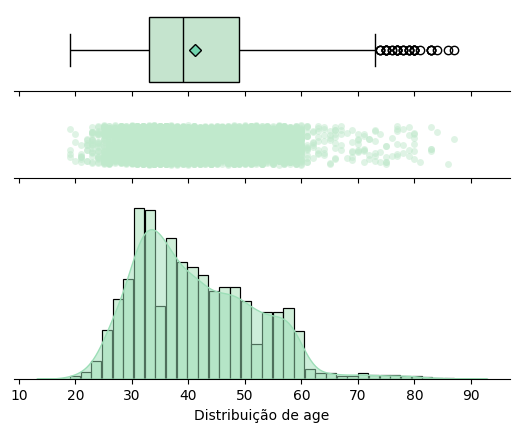

*************************** Resumo Estatístico **************************

A variável age possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
     Média Mediana
age  41.17   39.00

--- Medidas de Dispersão ------------------------------------------------
        dp     var    CV%  Skew    min    max Alcance
age  10.58  111.86  25.69  0.70  19.00  87.00   68.00

--- Medidas Separatrizes ------------------------------------------------
     Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
age     33.0     39.0     49.0              9.0             73.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 9.427573604575e-34 < 0.05. Os dados de age não seguem uma distribuição normal (Hipótese nula rejeitada).


In [30]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='age')
                                   

<code style="color:gold"> Insights age </code>
 - A média de idade é de aproximadamente 41.17 anos.
 - A idade dos clientes varia entre 19 a 87 anos.
 - A maioria dos clientes esta entre 33 e 49 anos.
 - Possui assimetria a direita, com variação de 25.69% dos dados em relação a média.
 - Possui outliers.
 - Os dados de age não seguem uma distribuição normal.

##### <code style="color:gold"> Variável job </code>

In [32]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='job')

,job,frequencia,porcentagem
11,unknown,38,0.840522
10,student,84,1.857996
9,housemaid,112,2.477328
8,unemployed,128,2.831232
7,entrepreneur,168,3.715992
6,self-employed,183,4.047777
5,retired,230,5.087370
4,services,417,9.223623
3,admin.,478,10.572882
2,technician,768,16.987392


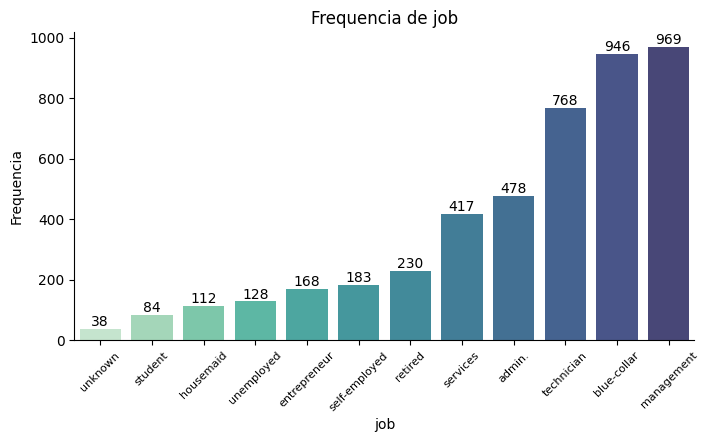

In [31]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='job')

<code style="color:gold"> Insights job </code>
 - Possui 12 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria dos clientes trabalha como management, com 21.43% dos casos.

##### <code style="color:gold"> Variável marital </code>

In [35]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='marital')

,marital,frequencia,porcentagem
2,divorced,528,11.678832
1,single,1196,26.454324
0,married,2797,61.866844


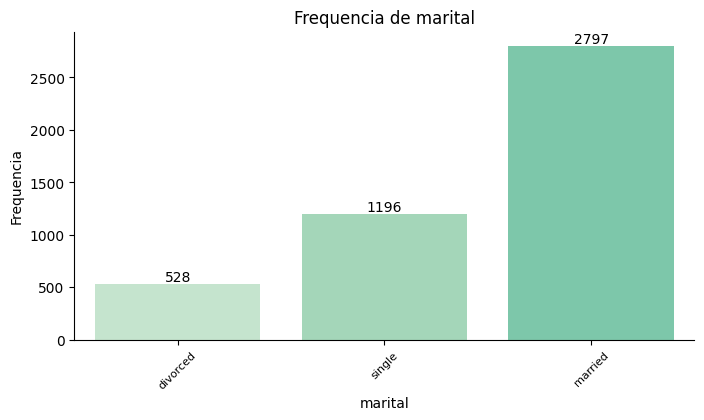

In [36]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='marital')

<code style="color:gold"> Insights marital </code>
 - Possui 3 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes é casada, com 61.87% dos casos.

##### <code style="color:gold"> Variável education </code>

In [37]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='education')

,education,frequencia,porcentagem
3,unknown,187,4.136253
2,primary,678,14.996682
1,tertiary,1350,29.860650
0,secondary,2306,51.006415


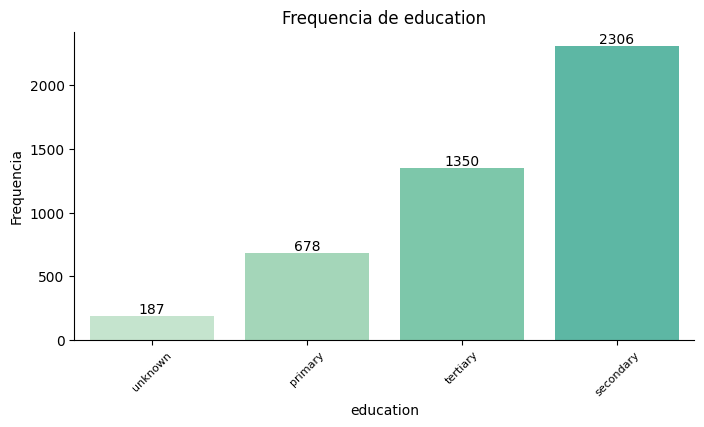

In [38]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='education')

<code style="color:gold"> Insights education </code>
 - Possui 4 grupos.
 - Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.
 - A maioria dos clientes tem o grau de educação secondary, com 51% dos casos.

##### <code style="color:gold"> Variável default </code>

In [39]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='default')

,default,frequencia,porcentagem
1,yes,76,1.681044
0,no,4445,98.318956


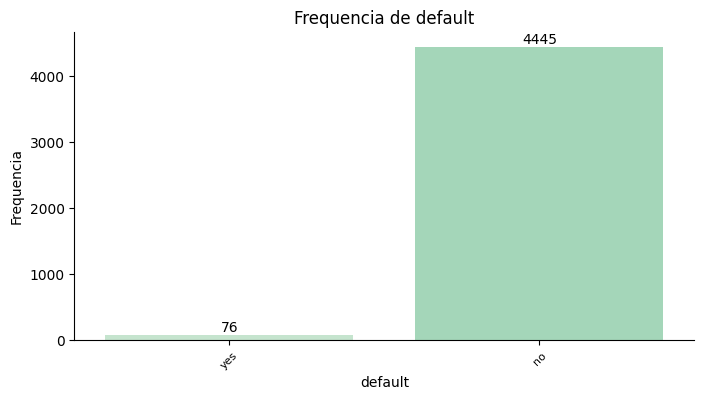

In [40]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='default')

<code style="color:gold"> Insights default </code>
 - Possui 2 grupos.
 - Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.
 - A maioria dos clientes não tem crédito em default, com 98.32% dos casos.

##### <code style="color:gold"> Variável balance </code>

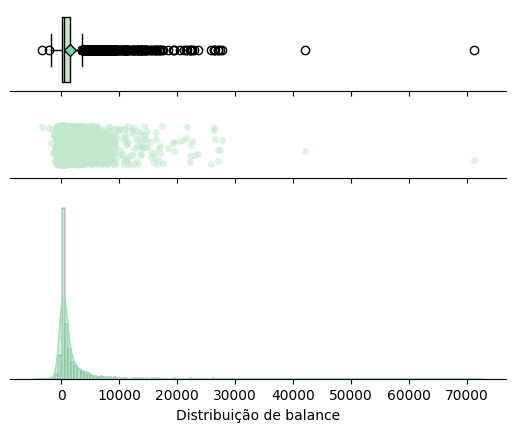

*************************** Resumo Estatístico **************************

A variável balance possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
           Média Mediana
balance  1422.66  444.00

--- Medidas de Dispersão ------------------------------------------------
              dp         var     CV%  Skew       min       max   Alcance
balance  3009.64  9057921.75  211.55  6.60  -3313.00  71188.00  74501.00

--- Medidas Separatrizes ------------------------------------------------
         Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
balance     69.0    444.0   1480.0          -2047.5           3596.5

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 1.124061228956861e-77 < 0.05. Os dados de balance não seguem uma distribuição normal (Hipótese nula rejeitada).


In [41]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='balance')

<code style="color:gold"> Insights balance </code>
 - A média do saldo médio anual é de aproximadamente 1422.66 euros.
 - O saldo médio anual varia entre -3313.00 a 71188.00 euros.
 - A maioria dos saldos médios anuais esta entre 69.0 e 444.0 anos.
 - Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média.
 - Possui outliers.
 - Os dados de balance não seguem uma distribuição normal.

##### <code style="color:gold"> Variável housing  </code>

In [42]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='housing')

,housing,frequencia,porcentagem
1,no,1962,43.397478
0,yes,2559,56.602522


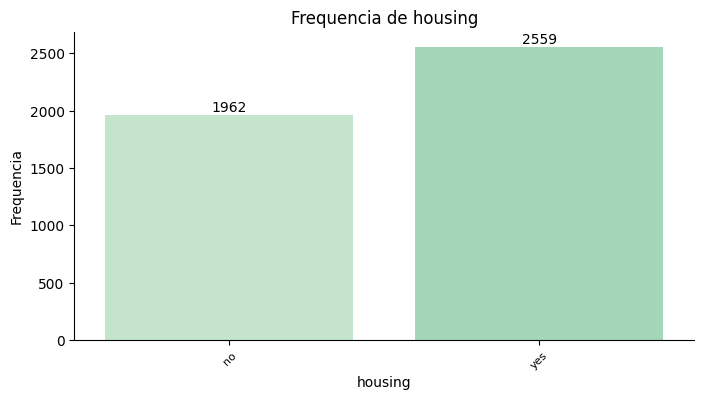

In [43]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='housing')

<code style="color:gold"> Insights housing </code>
 - Possui 2 grupos.
 - Os grupos possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.

##### <code style="color:gold"> Variável loan  </code>

In [44]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='loan')

,loan,frequencia,porcentagem
1,yes,691,15.284229
0,no,3830,84.715771


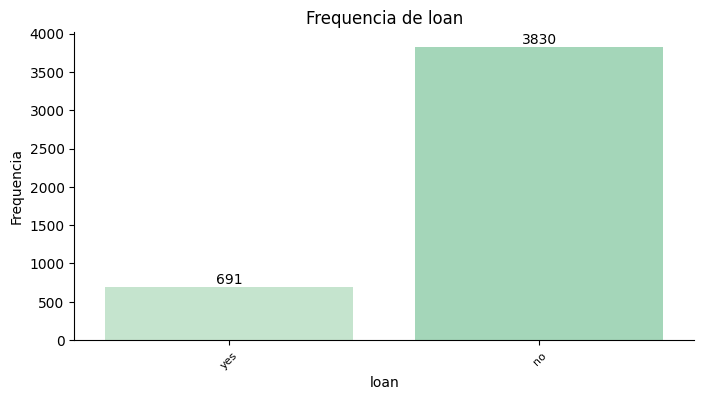

In [45]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='loan')

<code style="color:gold"> Insights loan </code>
 - Possui 2 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.

##### <code style="color:gold"> Variável contact  </code>

In [46]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='contact')

,contact,frequencia,porcentagem
2,telephone,301,6.657819
1,unknown,1324,29.285556
0,cellular,2896,64.056625


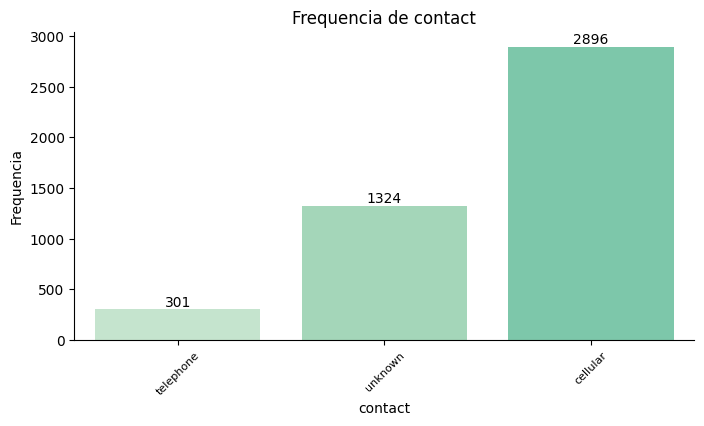

In [47]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='contact')

<code style="color:gold"> Insights contact </code>
 - Possui 3 grupos.
 - Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).
 - A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.

##### <code style="color:gold"> Variável day  </code>

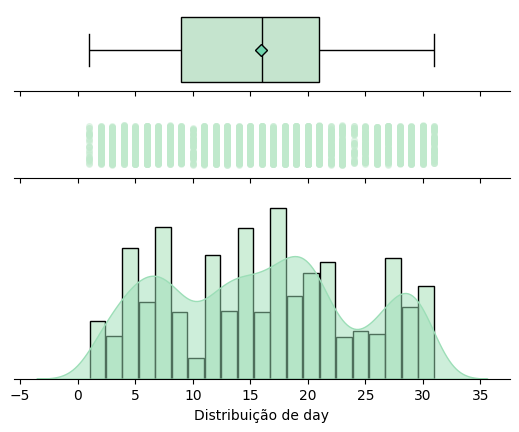

*************************** Resumo Estatístico **************************

A variável day possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
     Média Mediana
day  15.92   16.00

--- Medidas de Dispersão ------------------------------------------------
       dp    var    CV%  Skew   min    max Alcance
day  8.25  68.02  51.82  0.09  1.00  31.00   30.00

--- Medidas Separatrizes ------------------------------------------------
     Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
day      9.0     16.0     21.0             -9.0             39.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 2.459438015845874e-33 < 0.05. Os dados de day não seguem uma distribuição normal (Hipótese nula rejeitada).


In [48]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='day')

<code style="color:gold"> Insights day </code>
 - Na média, o ultimo dia de contato no mês é aproximadamente dia 16.
 - O ultimo dia de contato no mês varia entre 1 a 31.
 - A maioria do ultimo dia de contato no mês esta entre 9 e 21.
 - Não possui outliers.
 - Os dados de day não seguem uma distribuição normal.

##### <code style="color:gold"> Variável month </code>

In [52]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='month')

,month,frequencia,porcentagem
11,dec,20,0.442380
10,mar,49,1.083831
9,sep,52,1.150188
8,oct,80,1.769520
7,jan,148,3.273612
6,feb,222,4.910418
5,apr,293,6.480867
4,nov,389,8.604291
3,jun,531,11.745189
2,aug,633,14.001327


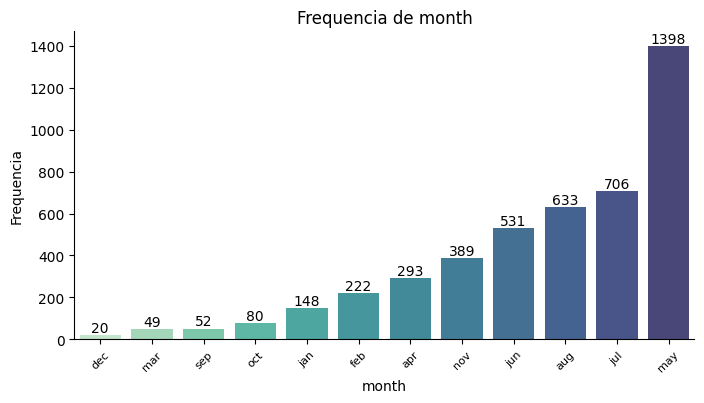

In [53]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='month')

<code style="color:gold"> Insights month </code>
 - Possui 12 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.

##### <code style="color:gold"> Variável duration </code>

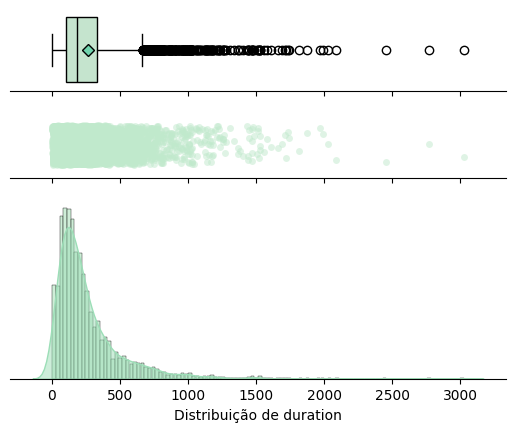

*************************** Resumo Estatístico **************************

A variável duration possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
           Média Mediana
duration  263.96  185.00

--- Medidas de Dispersão ------------------------------------------------
              dp       var    CV%  Skew   min      max  Alcance
duration  259.86  67525.47  98.44  2.77  4.00  3025.00  3021.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
duration    104.0    185.0    329.0           -233.5            666.5

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 6.241177661046895e-64 < 0.05. Os dados de duration não seguem uma distribuição normal (Hipótese nula rejeitada).


In [272]:
eda_bank_marketing.plot_distribuicao(coluna='duration')

<code style="color:gold"> Insights duration </code>
 - A média de duração do último contato foi de aproximadamente 263.96 segundos.
 - A duração do último contato varia de 4 a 3025 segundos.
 - A maioria da duração do último contato esta entre 104 e 329 segundos.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.
 - Possui outliers.
 - Os dados de duration não seguem uma distribuição normal.

##### <code style="color:gold"> Variável campaign </code>

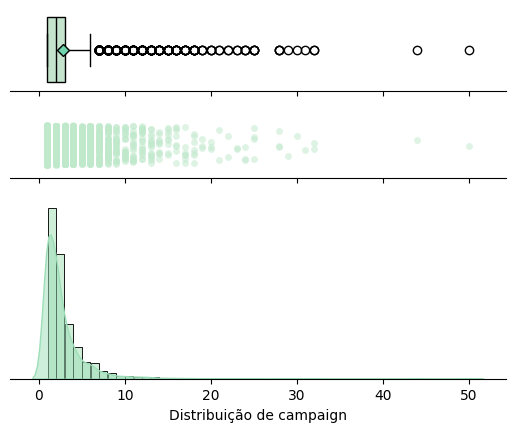

*************************** Resumo Estatístico **************************

A variável campaign possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
         Média Mediana
campaign  2.79    2.00

--- Medidas de Dispersão ------------------------------------------------
            dp   var     CV%  Skew   min    max Alcance
campaign  3.11  9.67  111.32  4.74  1.00  50.00   49.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
campaign      1.0      2.0      3.0             -2.0              6.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 5.174549847036246e-75 < 0.05. Os dados de campaign não seguem uma distribuição normal (Hipótese nula rejeitada).


In [54]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='campaign')

<code style="color:gold"> Insights campaign </code>
 - A média do número de contatos realizados durante esta campanha é de aproximadamente dia 2.79.
 - O número de contatos realizados durante esta campanha varia entre 1 a 50.
 - A maioria de contatos realizados durante esta campanha esta entre 1 e 3.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%.
 - Possui outliers.
 - Os dados de campaign não seguem uma distribuição normal.

##### <code style="color:gold"> Variável pdays  </code>

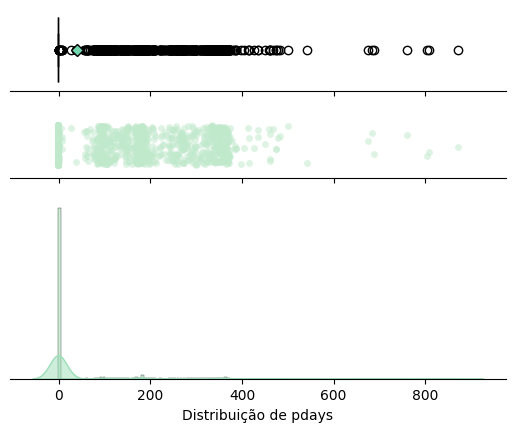

*************************** Resumo Estatístico **************************

A variável pdays possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
       Média Mediana
pdays  39.77   -1.00

--- Medidas de Dispersão ------------------------------------------------
           dp       var     CV%  Skew    min     max Alcance
pdays  100.12  10024.24  251.77  2.72  -1.00  871.00  872.00

--- Medidas Separatrizes ------------------------------------------------
       Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
pdays     -1.0     -1.0     -1.0             -1.0             -1.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 5.779153971271526e-79 < 0.05. Os dados de pdays não seguem uma distribuição normal (Hipótese nula rejeitada).


In [55]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='pdays')

<code style="color:gold"> Insights pdays </code>
 - A média do número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior é de aproximadamente 40 dias.
 - O número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior varia entre -1 a 871 dias.
 - A maioria do número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior é -1. Isto significa que o cliente não foi contatado anteriormente.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%.
 - Possui outliers.
 - Os dados de pdays não seguem uma distribuição normal.


##### <code style="color:gold"> Variável previous  </code>

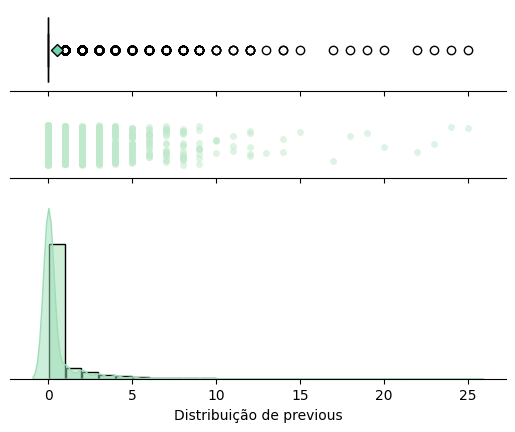

*************************** Resumo Estatístico **************************

A variável previous possui 4521 registros.

--- Medidas Tendencia Central -------------------------------------------
         Média Mediana
previous  0.54    0.00

--- Medidas de Dispersão ------------------------------------------------
            dp   var     CV%  Skew   min    max Alcance
previous  1.69  2.87  312.13  5.88  0.00  25.00   25.00

--- Medidas Separatrizes ------------------------------------------------
          Q1(25%)  Q2(50%)  Q3(75%)  Limite inferior  Limite Superior
previous      0.0      0.0      0.0              0.0              0.0

----- Teste de Normalidade dos dados (Shapiro) -----
H₀ - Hipótese Nula: Os dados seguem uma distribuição normal.
H₁ - Hipótese Alternativa: Os dados não seguem uma distribuição normal.
p_valor: 4.543066320674062e-83 < 0.05. Os dados de previous não seguem uma distribuição normal (Hipótese nula rejeitada).


In [56]:
# Distribuição das variáveis numéricas
eda_bank_marketing.plot_distribuicao(coluna='previous')

<code style="color:gold"> Insights previous </code>
 - A média do número de contatos realizados antes desta campanha é de aproximadamente 0.54.
 - O número de contatos realizados antes desta campanha varia entre 0 a 25.
 - A maioria do número de contatos realizados antes desta campanha é 0.
 - Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%.
 - Possui outliers.
 - Os dados de previous não seguem uma distribuição normal.

##### <code style="color:gold"> Variável poutcome  </code>

In [57]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='poutcome')

,poutcome,frequencia,porcentagem
3,success,129,2.853351
2,other,197,4.357443
1,failure,490,10.838310
0,unknown,3705,81.950896


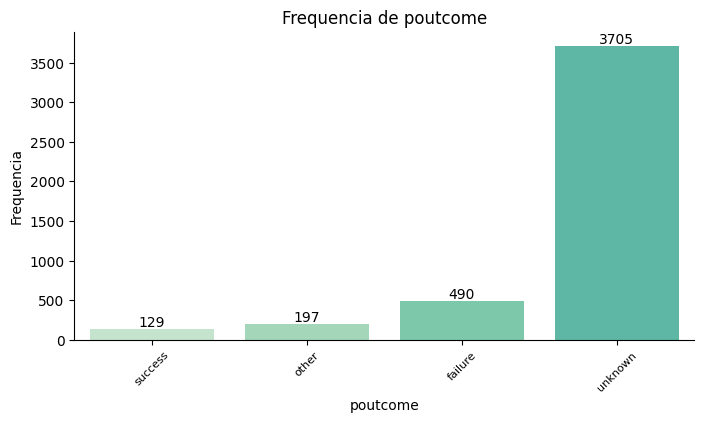

In [58]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='poutcome')

<code style="color:gold"> Insights poutcome </code>
 - Possui 4 grupos.
 - O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.
 - A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.

##### <code style="color:gold"> Variável y (target)  </code>

In [59]:
# Frequencia das variáveis categóricas
eda_bank_marketing.frequencia_cat(coluna='y')

,y,frequencia,porcentagem
1,yes,521,11.523999
0,no,4000,88.476001


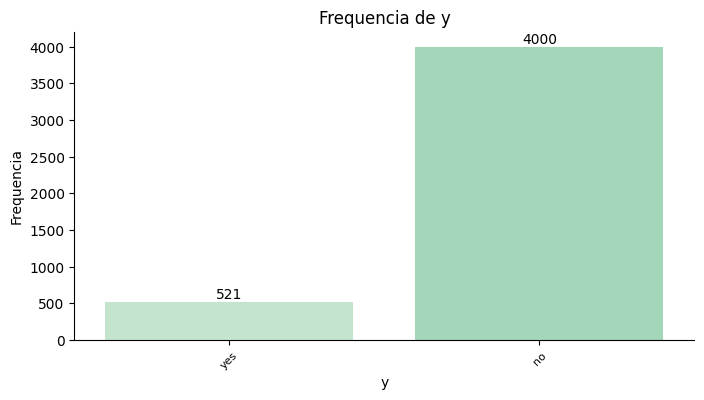

In [60]:
# Visualizar as categorias de uma variável categórica
eda_bank_marketing.plot_frequencia_cat(coluna='y')

<code style="color:gold"> Insights y (target) </code>
 - Possui 2 grupos.
 - O volume de dados entre os grupos é desbalanceado 12% para subscreveu um depósito a prazo e 88% para `não` subscreveu um depósito a prazo. Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.
 - Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.

### <code style="color:green"> Vamos atualizar nosso Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |Possui assimetria a direita, com variação de 25.69% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de age não seguem uma distribuição normal. |
| job    | categórico | Tipo de trabalho |Possui 12 grupos. | 
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros. |
|        |          |                    |A maioria dos clientes trabalha como management, com 21.43% dos casos. |
| marital   | categórico| Estado civil | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes é casada, com 61.87% dos casos. |
| education    | categórico| Educação |Possui 4 grupos. |
|        |          |                    |Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes tem o grau de educação secondary, com 51% dos casos. |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes não tem crédito em default, com 98.32% dos casos.|
| balance | numérico | saldo médio anual, em euros |Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de balance não seguem uma distribuição normal. |
| housing | binário: "yes","no" | tem empréstimo habitacional? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.|
| loan | binário: "yes","no" | tem empréstimo pessoal? |Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.|

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.|
| day | numérico |  último dia de contato do mês | Não possui outliers.|
|     |          |                               | Os dados de day não seguem uma distribuição normal.|
| month | categórico | último mês de contato do ano |Possui 12 grupos. |
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.|
| duration | numérico | duração do último contato, em segundos | Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.|
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de duration não seguem uma distribuição normal. |
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente (inclui o último contato) |Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) |Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
| poutcome | categórico | resultado da campanha de marketing anterior | Possui 4 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.|

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente subscreveu um depósito a prazo? | Possui 2 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado 12% para subscreveu um depósito a prazo e 88% para `não` subscreveu um depósito a prazo. Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.|
|        |          |                    |Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.|



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

### <code style="color:green">EDA - Análise exploratória Bivariada </code>

##### <code style="color:gold"> Verificando a multicolinearidade entre as variáveis independentes numéricas  </code>

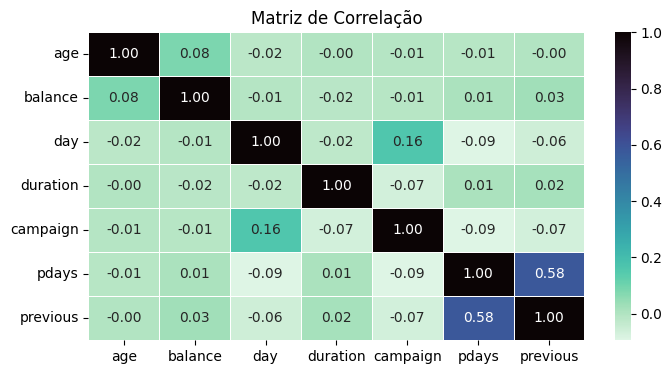

Utilizando o threshold (corte): 0.7, não foram encontrados casos de multicolinearidade.



In [107]:
# Testando a correlação de Pearson
eda_bank_marketing.pearson_corr(target="y", threshold=0.7)

### <code style="color:green"> Verificando a relação linear entre as variáveis independentes numéricas e a variável y (target)  </code>

#### <code style="color:gold"> Será necessario realizar um tratamento nos dados da variável y, convertendo yes=1 e no=0. </code>
 - Vou criar outra variavel chamada subscribed para armazenar essa modificação.

In [133]:
# Convertendo yes=1 e no=0 nos dados da variavel y
df_bank_marketing['subscribed'] = np.where(df_bank_marketing['y'] == 'yes', 1, 0)

##### <code style="color:gold"> Variável age e subscribed (target)  </code>

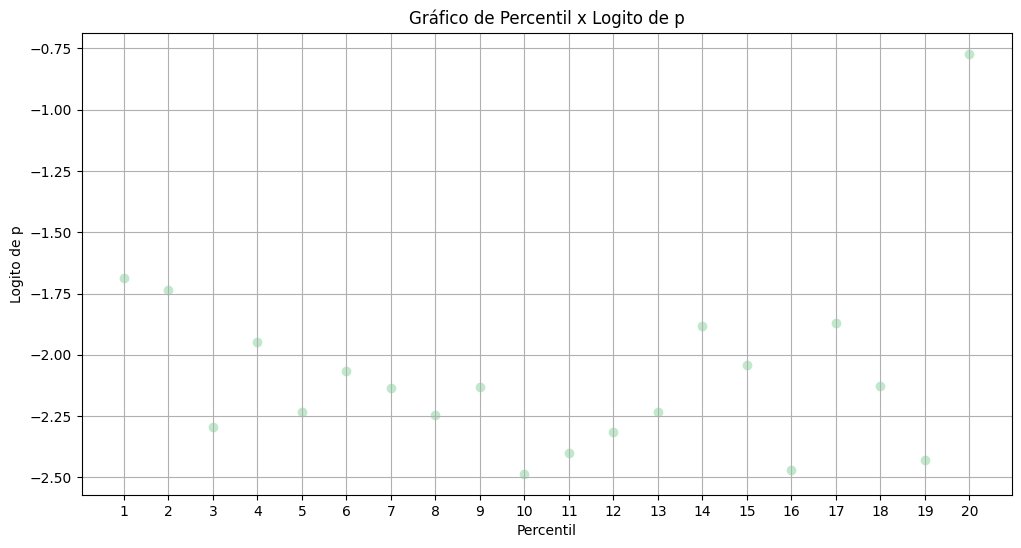

,percentil,n,min_x,max_x,p,logito_p
0,1,282,19,27,0.156028,-1.688081
1,2,200,28,29,0.150000,-1.734601
2,3,349,30,31,0.091691,-2.293166
3,4,224,32,32,0.125000,-1.945910
4,5,186,33,33,0.096774,-2.233592
5,6,231,34,34,0.112554,-2.064913
6,7,180,35,35,0.105556,-2.136965
7,8,188,36,36,0.095745,-2.245427
8,9,320,37,38,0.106250,-2.129631
9,10,130,39,39,0.076923,-2.484907


In [269]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='age', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `age` e `subscribed`. </code>

 Será necessário categorizar a variável `age`.

##### <code style="color:gold"> Variável balance e subscribed (target)  </code>

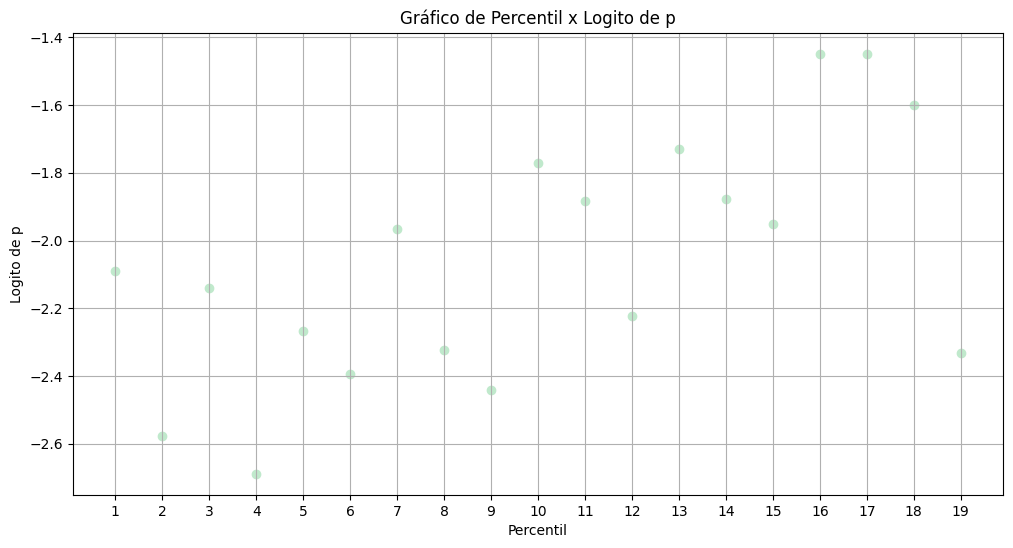

,percentil,n,min_x,max_x,p,logito_p
0,1,227,-3313,-162,0.110132,-2.089392
1,2,496,-154,0,0.070565,-2.578050
2,3,190,1,23,0.105263,-2.140066
3,4,220,24,69,0.063636,-2.688819
4,5,224,70,128,0.093750,-2.268684
5,6,227,130,194,0.083700,-2.393099
6,7,228,195,263,0.122807,-1.966113
7,8,224,264,351,0.089286,-2.322388
8,9,225,352,444,0.080000,-2.442347
9,10,227,445,574,0.145374,-1.771351


In [268]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='balance', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `balance` e `subscribed`. </code>

##### <code style="color:gold"> Variável day e subscribed (target)  </code>

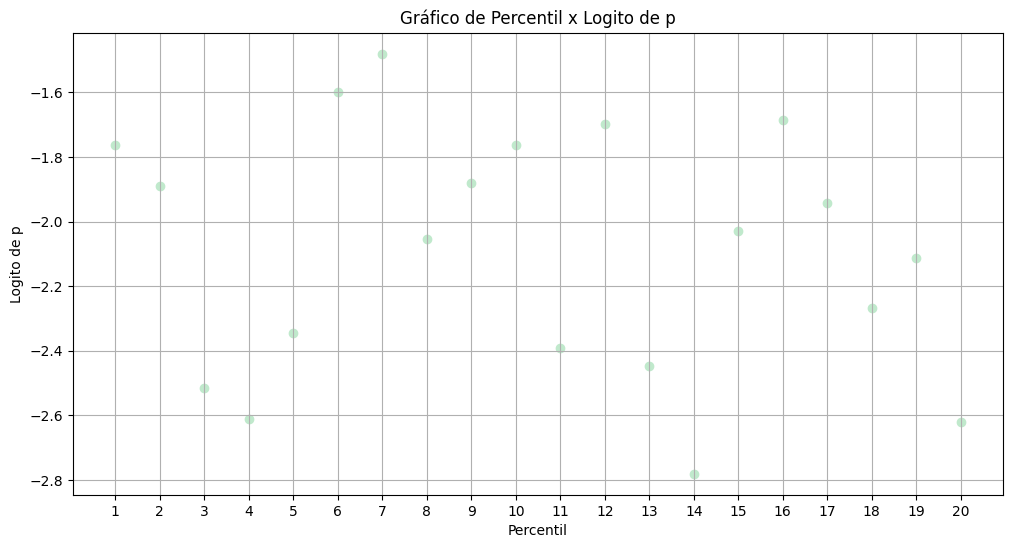

,percentil,n,min_x,max_x,p,logito_p
0,1,246,1,3,0.146341,-1.763589
1,2,320,4,5,0.131250,-1.889951
2,3,187,6,6,0.074866,-2.514234
3,4,190,7,7,0.068421,-2.611200
4,5,343,8,9,0.087464,-2.345006
5,6,202,10,11,0.168317,-1.597603
6,7,151,12,12,0.185430,-1.479980
7,8,361,13,14,0.113573,-2.054749
8,9,174,15,15,0.132184,-1.881786
9,10,164,16,16,0.146341,-1.763589


In [267]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='day', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `day` e `subscribed`. </code>

 Será necessário categorizar a variável `day`.

##### <code style="color:gold"> Variável duration e subscribed (target)  </code>

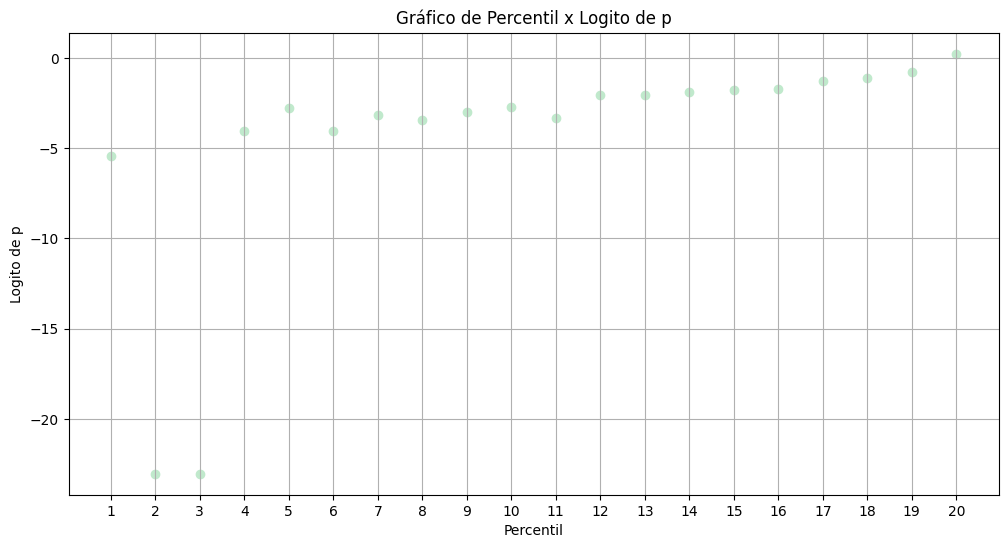

,percentil,n,min_x,max_x,p,logito_p
0,1,231,4,31,0.004329,-5.438079
1,2,237,32,58,0.000000,-23.025851
2,3,214,59,74,0.000000,-23.025851
3,4,235,75,89,0.017021,-4.056123
4,5,222,90,104,0.058559,-2.777385
5,6,232,105,119,0.017241,-4.043051
6,7,225,120,134,0.040000,-3.178054
7,8,221,135,149,0.031674,-3.420066
8,9,227,150,166,0.048458,-2.977383
9,10,224,167,185,0.062500,-2.708050


In [270]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='duration', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `duration` e `subscribed`. </code>

##### <code style="color:gold"> Variável campaign e subscribed (target)  </code>

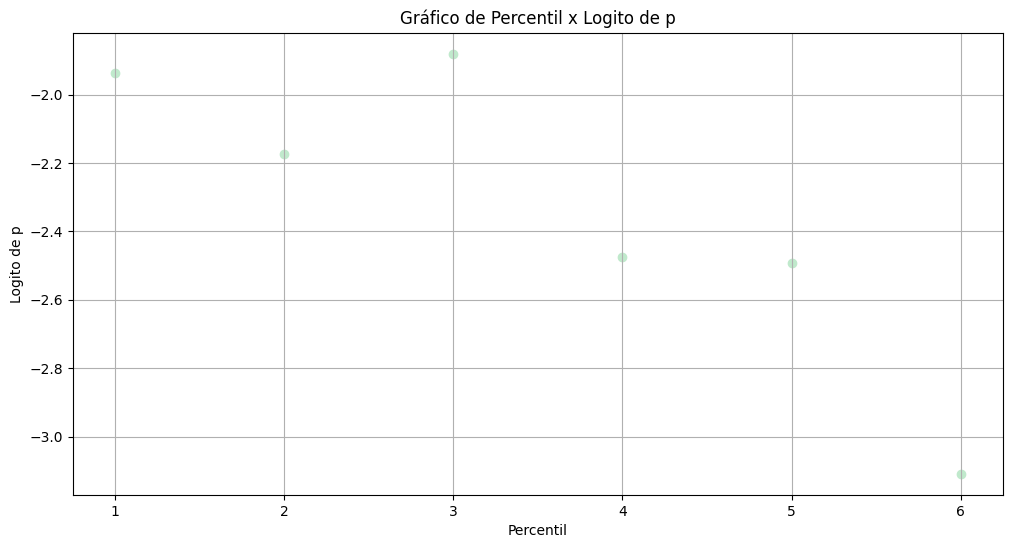

,percentil,n,min_x,max_x,p,logito_p
0,1,2998,1,2,0.126084,-1.936035
1,2,558,3,3,0.102151,-2.173555
2,3,325,4,4,0.132308,-1.880707
3,4,322,5,6,0.077640,-2.474856
4,5,131,7,8,0.076336,-2.493205
5,6,187,9,50,0.042781,-3.107944


In [271]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='campaign', y='subscribed', q=20, grafico='logito')

<code style="color:gold"> Através do gráfico consigo identificar uma relação linear entre `campaign` e `subscribed`. </code>

##### <code style="color:gold"> Variável pdays e subscribed (target)  </code>

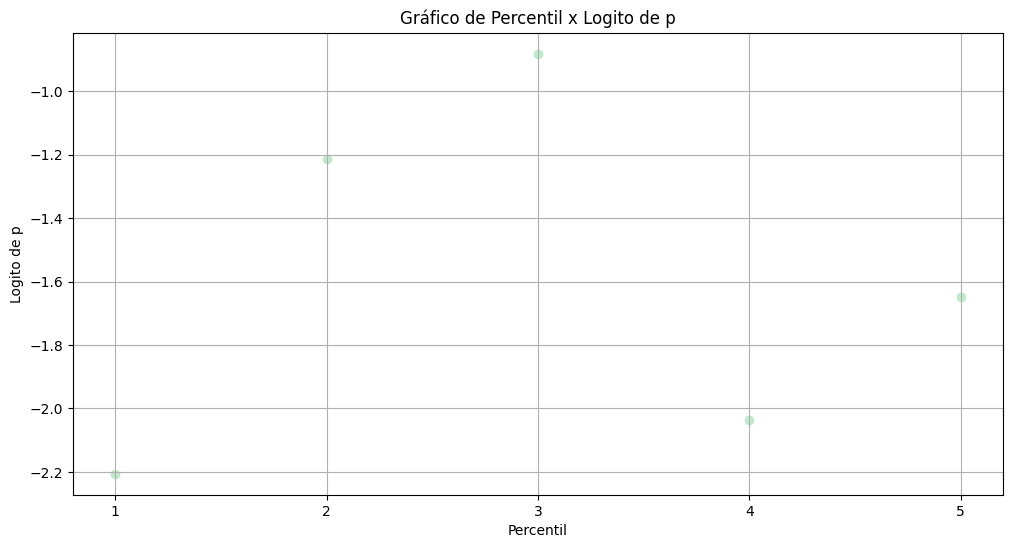

,percentil,n,min_x,max_x,p,logito_p
0,1,3799,-1,92,0.099237,-2.205735
1,2,179,93,168,0.229050,-1.213682
2,3,181,169,222,0.292818,-0.881738
3,4,182,223,337,0.115385,-2.036882
4,5,180,338,871,0.161111,-1.649984


In [263]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='pdays', y='subscribed', q=25, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `pdays` e `subscribed`. </code>

 Será necessário categorizar a variável `pdays`.

##### <code style="color:gold"> Variável previous e subscribed (target)  </code>

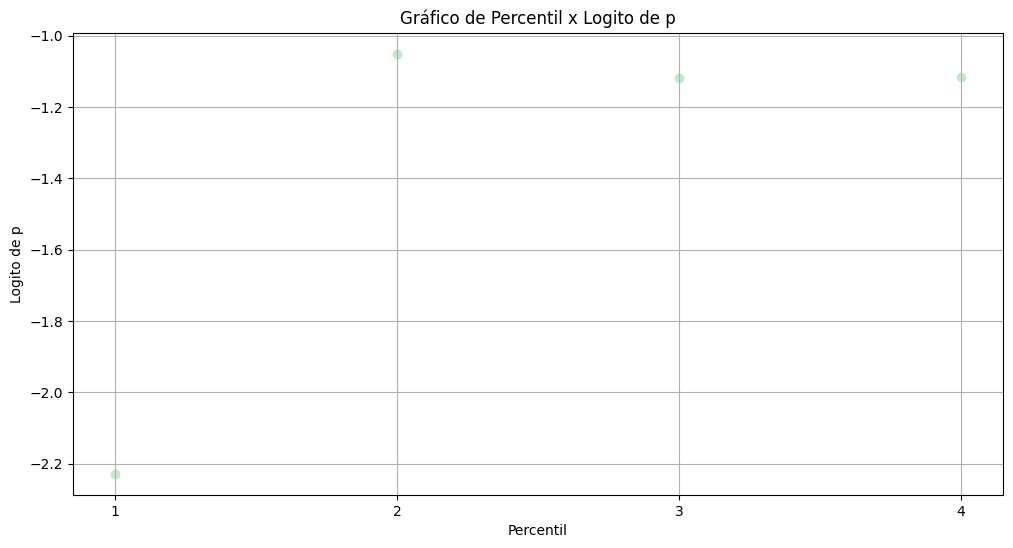

,percentil,n,min_x,max_x,p,logito_p
0,1,3991,0,1,0.097219,-2.228517
1,2,193,2,2,0.259067,-1.050822
2,3,191,3,4,0.246073,-1.119666
3,4,146,5,25,0.246575,-1.116961


In [266]:
rl.analise_var_numerica_por_percentil(data=df_bank_marketing, x='previous', y='subscribed', q=25, grafico='logito')

<code style="color:gold"> Através do gráfico não consigo identificar uma relação linear entre `previous` e `subscribed`. </code>

 Será necessário categorizar a variável `previous`.

<code style="color:gold"> Resumo da análise da relação linear entre as variáveis independentes númericas e `subscribed`. </code>
- As variáveis age, day, pdays e previous serão categorizadas, pois não foi comprovadada a relação linear com a variável subscribed.

### <code style="color:green"> Vamos atualizar nosso Dicionário de dados </code>

- <code style="color:gold"> Dados do cliente </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| age    | numérico | Idade do cliente   |Possui assimetria a direita, com variação de 25.69% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de age não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
| job    | categórico | Tipo de trabalho |Possui 12 grupos. | 
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros. |
|        |          |                    |A maioria dos clientes trabalha como management, com 21.43% dos casos. |
| marital   | categórico| Estado civil | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes é casada, com 61.87% dos casos. |
| education    | categórico| Educação |Possui 4 grupos. |
|        |          |                    |Os grupos estão desbalanceados. O grupo unknown possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes tem o grau de educação secondary, com 51% dos casos. |

- <code style="color:gold"> Dados bancários </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| default | binário: "yes","no" | tem crédito em default? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, sendo que grupo yes possui um volume de dados abaixo de 300 registros.|
|        |          |                    |A maioria dos clientes não tem crédito em default, com 98.32% dos casos.|
| balance | numérico | saldo médio anual, em euros |Possui forte assimetria a direita, com variação de 211.55% dos dados em relação a média. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de balance não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| housing | binário: "yes","no" | tem empréstimo habitacional? | Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes tem empréstimo habitacional, com 56.60% dos casos.|
| loan | binário: "yes","no" | tem empréstimo pessoal? |Possui 2 grupos. |
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes não tem empréstimo pessoal, com 84.72% dos casos.|

- <code style="color:gold"> Dados relacionados com o ultimo contato da campanha atual </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| contact | categórico | tipo de comunicação do contato | Possui 3 grupos.|
|        |          |                    |Os grupos estão desbalanceados, mas possuem um volume de dados adequado (> 300 registros).|
|        |          |                    |A maioria dos clientes foram contatados através do celular, com 64.05% dos casos.|
| day | numérico |  último dia de contato do mês | Não possui outliers.|
|     |          |                               | Os dados de day não seguem uma distribuição normal.|
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
| month | categórico | último mês de contato do ano |Possui 12 grupos. |
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do ultimo mês de contato do ano foi em maio, com 30.92% dos casos.|
| duration | numérico | duração do último contato, em segundos | Possui forte assimetria a direita, com variação dos dados em relação a média de 98.44%.|
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de duration não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| campaign | numérico | número de contatos realizados durante esta campanha e para este cliente (inclui o último contato) |Possui forte assimetria a direita, com variação dos dados em relação a média de 111.32%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Possui uma relação linear com y.|
| pdays | numérico | número de dias que se passaram desde que o cliente foi contatado pela última vez em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente) |Possui forte assimetria a direita, com variação dos dados em relação a média de 251.77%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
| previous | numérico | número de contatos realizados antes desta campanha e para este cliente | Possui forte assimetria a direita, com variação dos dados em relação a média de 312.13%. |
|        |          |                    |Possui outliers. |
|        |          |                    |Os dados de campaign não seguem uma distribuição normal. |
|        |          |                    |Sera categorizada. Não possui uma relação linear com y.|
| poutcome | categórico | resultado da campanha de marketing anterior | Possui 4 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado, com grupos com quantidade menor que 300 registros.|
|        |          |                    |A maioria do resultado da campanha de marketing anterior é unknown, com 81.95% dos casos.|

- <code style="color:gold"> Variável target (objetivo) </code>

| Variável  | Tipo  | Descrição   | Comentários   |
| :------- | :-------- | :-------- | :-------- |
| y | binário: "yes","no" | o cliente subscreveu um depósito a prazo? | Possui 2 grupos.|
|        |          |                    |O volume de dados entre os grupos é desbalanceado 12% para subscreveu um depósito a prazo e 88% para `não` subscreveu um depósito a prazo. Por se tratar da variável do objetivo desejado, este desbalanceamento, precisa de atenção.|
|        |          |                    |Será necessario realizar um tratamento nos dados, convertendo yes=1 e no=0.|



<code style="color:gold"> Referência: </code>

  This dataset is public available for research. The details are described in [Moro et al., 2011]. 

  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

In [274]:
df_bank_marketing.loc[df_bank_marketing['pdays'] == -1, 'pdays'].count()

np.int64(3705)

In [276]:
df_bank_marketing.loc[df_bank_marketing['previous'] == 0, 'previous'].count()

np.int64(3705)

### <code style="color:green"> Analisando o nível de associação entre as variáveis independentes categóricas e subscribed (target)   </code>

- Vamos utilizar o teste de Hipóteses qui-quadrado e teste V de Cramer.

##### <code style="color:gold"> Variável job e subscribed (target)  </code>

In [324]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='job', target='subscribed')

,job,subscribed,frequencia,porcentagem
0,admin.,0,420,87.866109
1,admin.,1,58,12.133891
2,blue-collar,0,877,92.706131
3,blue-collar,1,69,7.293869
4,entrepreneur,0,153,91.071429
5,entrepreneur,1,15,8.928571
6,housemaid,0,98,87.500000
7,housemaid,1,14,12.500000
8,management,0,838,86.480908
9,management,1,131,13.519092


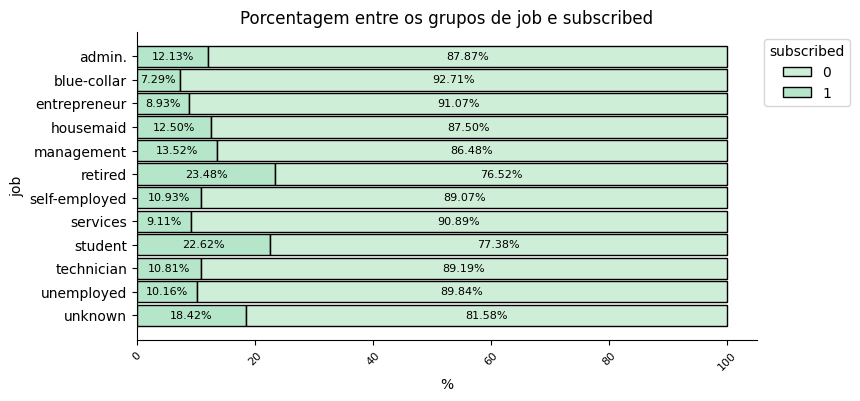

In [361]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='job', target='subscribed', orient='h')

In [336]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='job', var_categorica2='subscribed')


----- Hipóteses -----
H0 : Não existe associação entre as variáveis job e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis job e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 68.98828575267176
P_valor: 1.901391096662705e-10

----- Conclusão -----
- p_valor: 0.0000000002 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis job e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1235294260


##### <code style="color:gold"> Variável marital e subscribed (target)  </code>

In [331]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='marital', target='subscribed')

,marital,subscribed,frequencia,porcentagem
0,divorced,0,451,85.416667
1,divorced,1,77,14.583333
2,married,0,2520,90.096532
3,married,1,277,9.903468
4,single,0,1029,86.036789
5,single,1,167,13.963211


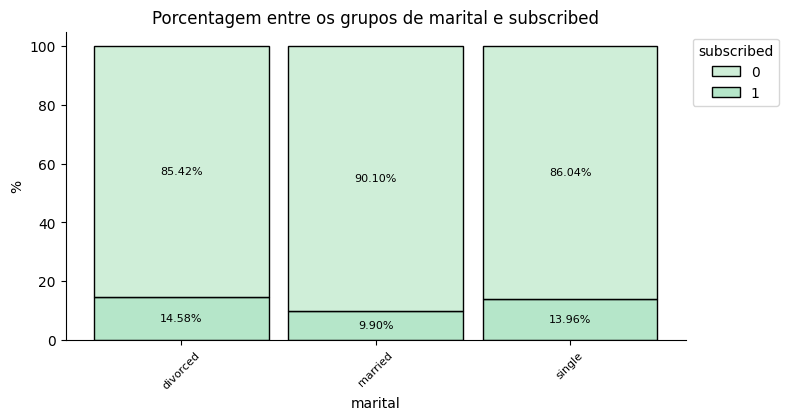

In [366]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='marital', target='subscribed', orient='v')

In [337]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='marital', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis marital e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis marital e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 19.03005634409817
P_valor: 7.373535401823763e-05

----- Conclusão -----
- p_valor: 0.0000737354 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis marital e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0648787963


##### <code style="color:gold"> Variável education e subscribed (target)  </code>

In [338]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed')

,education,subscribed,frequencia,porcentagem
0,primary,0,614,90.560472
1,primary,1,64,9.439528
2,secondary,0,2061,89.375542
3,secondary,1,245,10.624458
4,tertiary,0,1157,85.703704
5,tertiary,1,193,14.296296
6,unknown,0,168,89.839572
7,unknown,1,19,10.160428


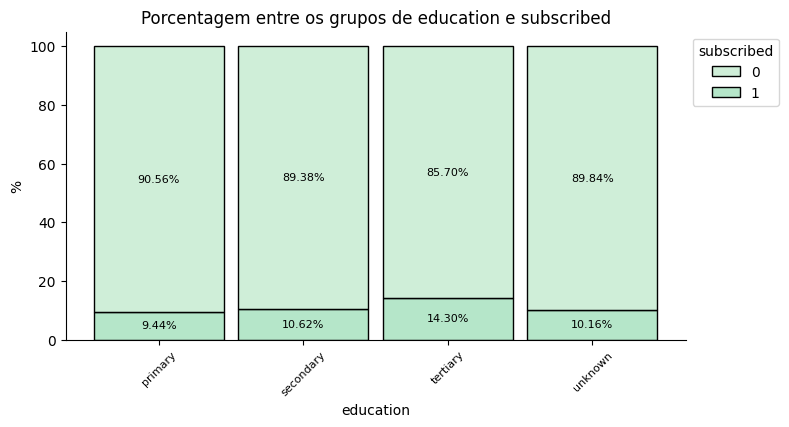

In [367]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed', orient='v')

In [340]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='education', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis education e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis education e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 15.236579554873757
P_valor: 0.001625240003630989

----- Conclusão -----
- p_valor: 0.0016252400 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis education e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0580532434


##### <code style="color:gold"> Variável default e subscribed (target)  </code>

In [341]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='default', target='subscribed')

,default,subscribed,frequencia,porcentagem
0,no,0,3933,88.481440
1,no,1,512,11.518560
2,yes,0,67,88.157895
3,yes,1,9,11.842105


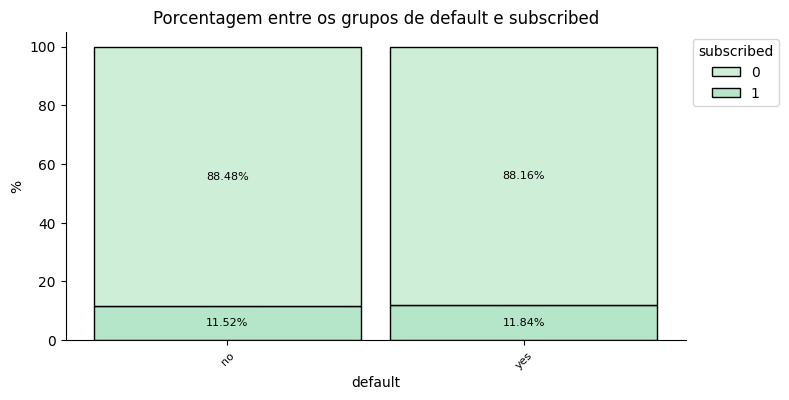

In [368]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='default', target='subscribed', orient='v')

In [345]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='default', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis default e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis default e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 0.0
P_valor: 1.0

----- Conclusão -----
- p_valor: 1.0000000000 > alpha: 0.05 => Não rejeitamos a hipótese nula. Não existe associação entre as variáveis default e subscribed
- Tamanho do Efeito - Cramér´s V: 0.0013026526


##### <code style="color:gold"> Variável housing e subscribed (target)  </code>

In [346]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='housing', target='subscribed')

,housing,subscribed,frequencia,porcentagem
0,no,0,1661,84.658512
1,no,1,301,15.341488
2,yes,0,2339,91.402892
3,yes,1,220,8.597108


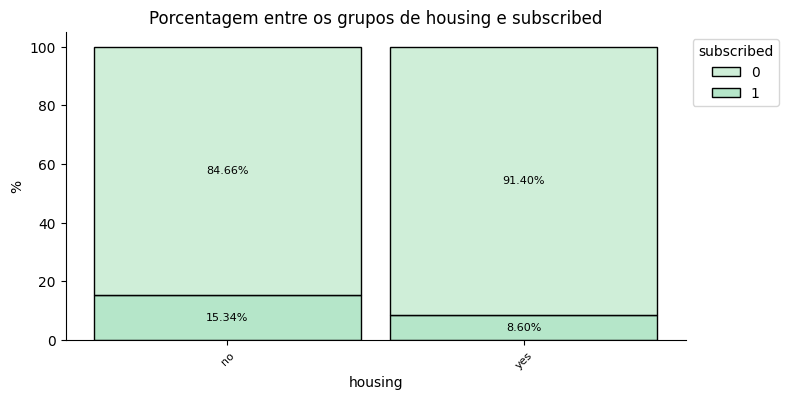

In [369]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='housing', target='subscribed', orient='v')

In [348]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='housing', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis housing e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis housing e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 48.88462833144263
P_valor: 2.7146998959323014e-12

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis housing e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1046834004


##### <code style="color:gold"> Variável loan e subscribed (target)  </code>

In [349]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='loan', target='subscribed')

,loan,subscribed,frequencia,porcentagem
0,no,0,3352,87.519582
1,no,1,478,12.480418
2,yes,0,648,93.777135
3,yes,1,43,6.222865


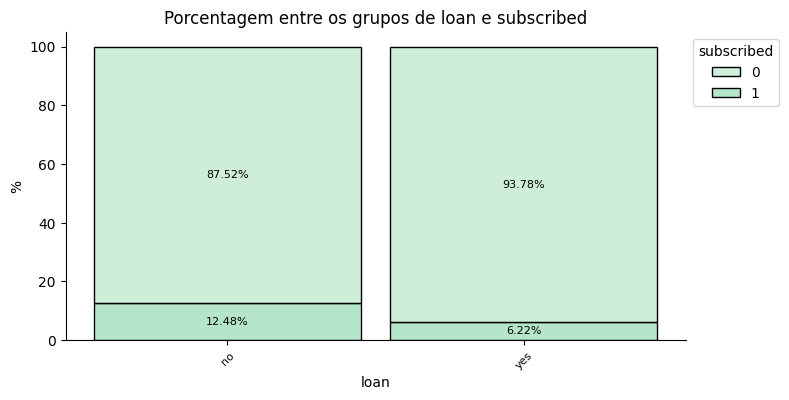

In [370]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='loan', target='subscribed', orient='v')

In [351]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='loan', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis loan e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis loan e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 21.87182161746215
P_valor: 2.9148288298428256e-06

----- Conclusão -----
- p_valor: 0.0000029148 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis loan e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.0705170352


##### <code style="color:gold"> Variável contact e subscribed (target)  </code>

In [352]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='contact', target='subscribed')

,contact,subscribed,frequencia,porcentagem
0,cellular,0,2480,85.635359
1,cellular,1,416,14.364641
2,telephone,0,257,85.382060
3,telephone,1,44,14.617940
4,unknown,0,1263,95.392749
5,unknown,1,61,4.607251


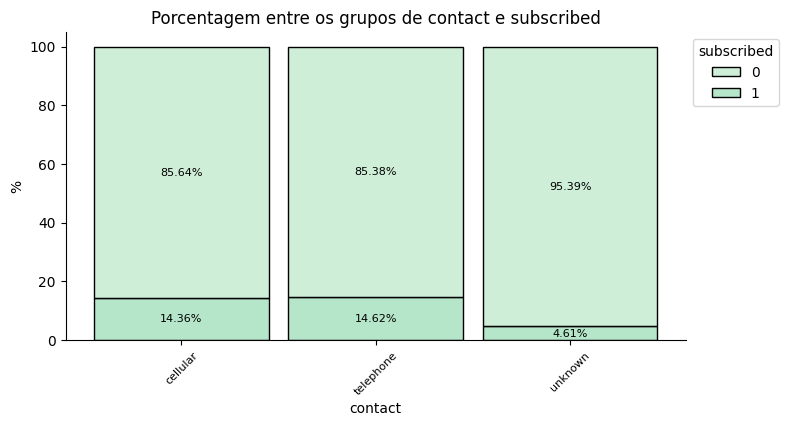

In [371]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='contact', target='subscribed', orient='v')

In [354]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='contact', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis contact e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis contact e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 87.86985650165812
P_valor: 8.30430129641147e-20

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis contact e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.1394128178


##### <code style="color:gold"> Variável month e subscribed (target)  </code>

In [355]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='month', target='subscribed')

,month,subscribed,frequencia,porcentagem
0,apr,0,237,80.887372
1,apr,1,56,19.112628
2,aug,0,554,87.519747
3,aug,1,79,12.480253
4,dec,0,11,55.000000
5,dec,1,9,45.000000
6,feb,0,184,82.882883
7,feb,1,38,17.117117
8,jan,0,132,89.189189
9,jan,1,16,10.810811


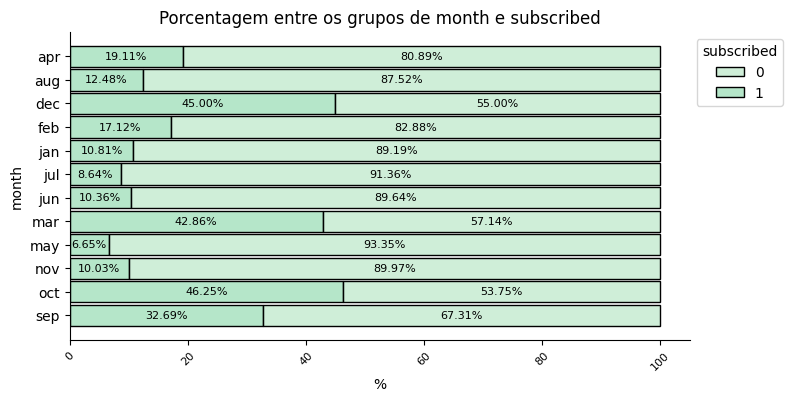

In [360]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='month', target='subscribed', orient='h')

In [362]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='month', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis month e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis month e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 250.50006340911358
P_valor: 2.195354833570811e-47

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis month e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.2353892724


##### <code style="color:gold"> Variável poutcome e subscribed (target)  </code>

In [363]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='poutcome', target='subscribed')

,poutcome,subscribed,frequencia,porcentagem
0,failure,0,427,87.142857
1,failure,1,63,12.857143
2,other,0,159,80.710660
3,other,1,38,19.289340
5,success,0,46,35.658915
4,success,1,83,64.341085
6,unknown,0,3368,90.904184
7,unknown,1,337,9.095816


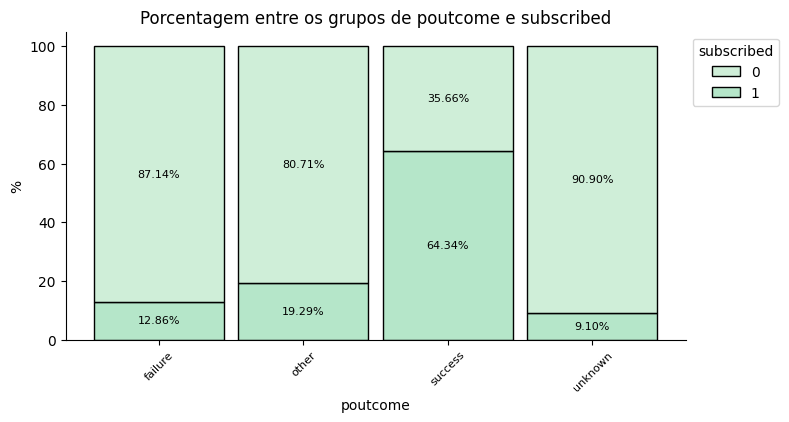

In [372]:
# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='poutcome', target='subscribed', orient='v')

In [365]:
# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='poutcome', var_categorica2='subscribed')

----- Hipóteses -----
H0 : Não existe associação entre as variáveis poutcome e subscribed. As frequencias são estatisticamente iguais.
H1 : Existe associação entre as variáveis poutcome e subscribed. As frequencias são estatisticamente diferentes.
Nível de significância de 0.05.
---------------------

Valor do teste qui-quadrado: 386.8773872252409
P_valor: 1.5398831095860172e-83

----- Conclusão -----
- p_valor: 0.0000000000 < alpha: 0.05 => Rejeitamos a hipótese nula. Existe associação entre as variáveis poutcome e subscribed.
- Tamanho do Efeito - Cramér´s V: 0.2925293321


In [323]:
df_bank_marketing.select_dtypes(exclude=['int64', 'float64']).columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

##### <code style="color:gold"> Variável default e subscribed (target)  </code>

In [ ]:
# Frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed')

# Gráfico de frequência e porcentagem entre os grupos de uma variável categórica e a variável alvo
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed', orient='v')

# Realizando o teste qui-quadrado de independência
ht.teste_chi2(dataframe=df_bank_marketing, var_categorica1='education', var_categorica2='subscribed')

In [319]:
eda_bank_marketing.taxa_resposta(var_categorica='education', target='subscribed')

,education,frequencia,taxa_resposta
0,primary,678,0.094395
1,secondary,2306,0.106245
2,tertiary,1350,0.142963
3,unknown,187,0.101604


In [320]:
eda_bank_marketing.freq_porcentagem_entre_grp_target(var_categorica='education', target='y')

,education,y,frequencia,porcentagem
0,primary,no,614,90.560472
1,primary,yes,64,9.439528
2,secondary,no,2061,89.375542
3,secondary,yes,245,10.624458
4,tertiary,no,1157,85.703704
5,tertiary,yes,193,14.296296
6,unknown,no,168,89.839572
7,unknown,yes,19,10.160428


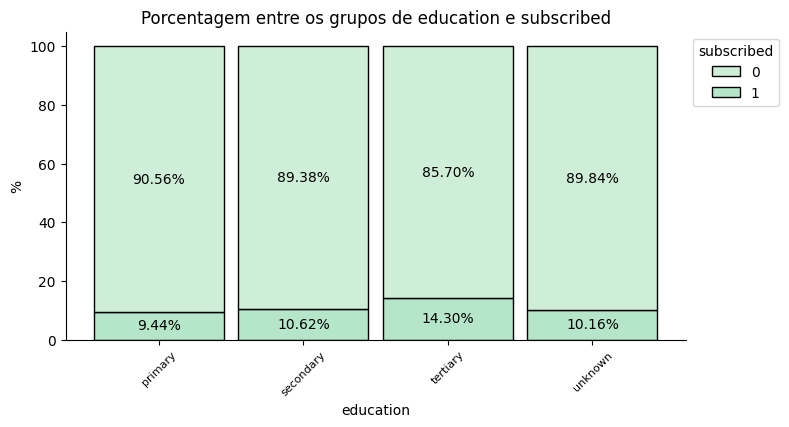

In [321]:
eda_bank_marketing.plot_freq_porcentagem_entre_grp_target(var_categorica='education', target='subscribed')

In [ ]:
# Criando uma lista de tuplas com a combinação de 2 variáveis 
vars = ['Basement_Area', 'Lot_Area', 'Gr_Liv_Area', 'Garage_Area', 'Deck_Porch_Area',
         'Age_Sold','Bedroom_AbvGr', 'Total_Bathroom']
tupla_cols = []
col = 'SalePrice'
for col1 in (vars):
    tupla_cols.append((col,col1))

fig, axs = plt.subplots(len(vars),1, figsize=(8,40),dpi=75)
fig.subplots_adjust(hspace=0.5, wspace=1)  # Ajusta espaçamento vertical (hspace) e horizontal (wspace) 
for ax, i in zip(axs.flat, range(len(tupla_cols))):
  sns.scatterplot(x=tupla_cols[i][1], y=tupla_cols[i][0], data=df_precos_casas, color='blue', ax=ax)
  sns.despine()

In [359]:
reload(eda)
eda_bank_marketing = eda.Eda_lib(dataframe=df_bank_marketing, nome="df_bank_marketing", colormap="mako_r" )

In [255]:
reload(rl)

<module 'regressao_log_lib' from 'd:\\Repositorio\\DataScience\\Case\\bank_marketing\\bank_marketing\\regressao_log_lib.py'>

In [344]:
reload(ht)

<module 'hipoteses_lib' from 'd:\\Repositorio\\DataScience\\Case\\bank_marketing\\bank_marketing\\hipoteses_lib.py'>